# <a id='toc1_'></a>[UCRB PET Analysis](#toc0_)
Author: Daniel Hogan

Created: September 7, 2023

This notebook will take in temperature data from PRISM and calculate PET using the Thornthwaite equation. It will then compare these reults to another PET product from TerraClimate. A section is devoted to exploring PET from a 1-km WRF run over 2 HCDN basins between 1987-2020 but that data will not be available here (a link to the dataset is provided below). Lastly, we compare the spring temperature/precipitation relationship to the trend in temperature to see which is greater. 

**Table of contents**<a id='toc0_'></a>    
- [UCRB PET Analysis](#toc1_)    
    - [Imports](#toc1_1_1_)    
- [Pull in boundary data](#toc2_)    
- [Pull in the PRISM Data PPT and T](#toc3_)    
    - [PRISM UCRB Precipitation](#toc3_1_1_)    
    - [PRISM UCRB Temperature](#toc3_1_2_)    
- [Compare PET and PPT products over spring](#toc4_)    
    - [Pull in nClimGrid precipitation](#toc4_1_1_)    
    - [Pull in PPT from ERA5-Land](#toc4_1_2_)    
    - [Pull in PET and ET from ERA5](#toc4_1_3_)    
    - [Calculate Priestley-Taylor PET from ERA5-Land variables](#toc4_1_4_)    
    - [Pull in PET-energy only from ERA5-Land](#toc4_1_5_)    
    - [Pull in PET from CRU](#toc4_1_6_)    
    - [Pull in GLEAM data](#toc4_1_7_)    
    - [Pull in P-LSH ET data](#toc4_1_8_)    
- [Plot PET against PPT and Cloud Cover](#toc5_)    
    - [PET-Energy only from ERA5, ERA5 cloud cover, and PPT](#toc5_1_1_)    
    - [CRU PET with CRU cloud cover and PPT](#toc5_1_2_)    
    - [GLEAM PET with cloud cover and PPT (1980-2022)](#toc5_1_3_)    
    - [P-LSH ET with cloud cover and PPT](#toc5_1_4_)    
- [PET and Snow Cover with elevation](#toc6_)    
      - [NLCD Land Cover](#toc6_1_1_1_)    
    - [Get MODIS SCA](#toc6_1_2_)    
    - [Get more accurate tree covered area](#toc6_1_3_)    
    - [Hypsometric Figures](#toc6_1_4_)    
- [Plot PET against Spring P colored by Tmean](#toc7_)    
    - [Assessing temporal trend in temperature vs. spring preciptiation relationship](#toc7_1_1_)    
  - [PRISM UCRB Thornthwaite Estimate](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Imports](#toc0_)

In [1]:
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
# from pyeto import fao
import numpy as np
from scipy.stats.stats import pearsonr, spearmanr
import scipy.stats as stats
from pyeto import thornthwaite, monthly_mean_daylight_hours, deg2rad


/tmp/ipykernel_613/3014695817.py:11: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr
/tmp/ipykernel_613/3014695817.py:11: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr


# <a id='toc2_'></a>[Pull in boundary data](#toc0_)

In [2]:
# LCC projection for the Upper Colorado River Basin
lcc_proj = "+proj=lcc +lat_0=50 +lon_0=-107 +lat_1=50 +lat_2=50 +x_0=5632642.22547 +y_0=4612545.65137 +datum=WGS84 +units=m +no_defs" 

# Read in the UCRB boundary
ucrb_boundary = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary_4326 = ucrb_boundary.copy()
ucrb_boundary=ucrb_boundary.to_crs(lcc_proj) # reprojection to LCC

# Read in the HCDN boundaries
hcdn_boundaries = gpd.read_file('../data/geodata/ucrb_selected_basins.geojson')
hcdn_boundaries=hcdn_boundaries.set_crs(epsg=32613,allow_override=True)
hcdn_boundaries_4326=hcdn_boundaries.to_crs(4326) # reprojection to 4326


# <a id='toc3_'></a>[Pull in the PRISM Data PPT and T](#toc0_)

### <a id='toc3_1_1_'></a>[PRISM UCRB Precipitation](#toc0_)

In [3]:
# Open PRISM precipitation data
prism_ppt = rxr.open_rasterio('../data/precipdata/prism_4km_ucrb.nc')
# convert crs to match the UCRB boundary
prism_ppt = prism_ppt.rio.reproject(4326)
prism_ppt = prism_ppt.where(prism_ppt>=0,drop=True)

In [4]:
# Get seasonal total precipitation for the UCRB over spring
ucrb_spring_ppt = prism_ppt.where(prism_ppt['month'].dt.month.isin([3,4,5]),drop=True).groupby('month.year').sum()
ucrb_spring_ppt = ucrb_spring_ppt.where(ucrb_spring_ppt>0,drop=True)#.sel(year=slice(1964,2022))

### <a id='toc3_1_2_'></a>[PRISM UCRB Temperature](#toc0_)

In [5]:
# Open PRISM temperature data
prism_tmean = rxr.open_rasterio('../data/etdata/prism_tmean_4km_ucrb.nc')
# reprject to match the UCRB boundary
prism_tmean = prism_tmean.rio.reproject(4326)
prism_tmean = prism_tmean.where(prism_tmean>-100,drop=True).sel(month=slice('1930-01-01','2022-09-30'))
spring_mean_ucrb_temp = prism_tmean.where(prism_tmean['month'].dt.month.isin([3,4,5]),drop=True).groupby('month.year').mean()
# calculate spring mean temperature anomaly
spring_mean_ucrb_temp_anomaly = spring_mean_ucrb_temp - spring_mean_ucrb_temp.mean('year')

In [6]:
# add the year as a new dimension to prism_tmean
prism_tmean = prism_tmean.assign_coords(year=prism_tmean['month'].dt.year)

# make a copy to use later
prism_tmean_copy = prism_tmean.copy()
prism_tmean_copy['month'] = prism_tmean_copy['month'].dt.year

# <a id='toc4_'></a>[Compare PET and PPT products over spring](#toc0_)
### <a id='toc4_1_1_'></a>[Pull in nClimGrid precipitation](#toc0_)

In [7]:
nclimgrid_ds = xr.open_dataset('../data/precipdata/nclimgrid_5km_ucrb.nc')
nclimgrid_ds = nclimgrid_ds.rio.write_crs(4326)
spring_nclimgrid_ds = nclimgrid_ds.where(nclimgrid_ds['time'].dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')
spring_nclimgrid_ds = spring_nclimgrid_ds.where(spring_nclimgrid_ds>0,np.nan)
hcdn_spring_nclimgrid_ds = spring_nclimgrid_ds.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)
hcdn_spring_nclimgrid_ds = hcdn_spring_nclimgrid_ds.where(hcdn_spring_nclimgrid_ds>0,np.nan)
hcdn_spring_ppt_nclimgrid_mean = hcdn_spring_nclimgrid_ds.mean(dim=['y','x']).sel(year=slice(1982,2013))
hcdn_spring_ppt_nclimgrid_mean_2 = hcdn_spring_nclimgrid_ds.mean(dim=['y','x']).sel(year=slice(1964,2022))

In [8]:
# Grba PRISM spring data and clip to HCDN boundaries
ucrb_spring_ppt = prism_ppt.where(prism_ppt['month'].dt.month.isin([3,4,5]),drop=True).groupby('month.year').sum()
# replace negative values with nan
ucrb_spring_ppt = ucrb_spring_ppt.where(ucrb_spring_ppt>0,drop=True)
hcdn_spring_ppt_prism = ucrb_spring_ppt.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)
hcdn_spring_ppt_prism = hcdn_spring_ppt_prism.where(hcdn_spring_ppt_prism>0,np.nan)
hcdn_spring_ppt_prism_mean = hcdn_spring_ppt_prism.mean(dim=['x','y']).sel(year=slice(1982,2013))
hcdn_spring_ppt_prism_mean_2 = hcdn_spring_ppt_prism.mean(dim=['x','y']).sel(year=slice(1964,2022))


### <a id='toc4_1_2_'></a>[Pull in PPT from ERA5-Land](#toc0_)

In [9]:
era5_land_ds = xr.open_dataset('../data/precipdata/ERA5-land-monthly-1963-2022-UCRB.nc')
era5_land_ds = era5_land_ds.rio.write_crs(4326)
era5_land_ds_hcdn = era5_land_ds.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)
era5_land_ds_ucrb = era5_land_ds.rio.clip(ucrb_boundary_4326.geometry, all_touched=True)

# calculate the spring totals for each year
era5_land_spring = era5_land_ds_hcdn.where(era5_land_ds_hcdn.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')
# make zero values nan
era5_land_spring = era5_land_spring.where(era5_land_spring>0, np.nan)
# calculate spatial mean    
hcdn_era5_land_spring_mean = era5_land_spring.mean(dim=['latitude','longitude']).sel(year=slice(1964,2022))


### <a id='toc4_1_3_'></a>[Pull in PET and ET from ERA5](#toc0_)

In [10]:
era5_et = xr.open_dataset('../data/etdata/ERA5_pet_et_clouds.nc')
era5_et = era5_et.rio.write_crs(4326)
# convert e and pev to mm/month from -1 * m/day by multiplying by days in each month
era5_et['month_days'] = era5_et.time.dt.days_in_month
era5_et['e'] = era5_et['e'] * era5_et['month_days'] * 1000 * -1
era5_et['pev'] = era5_et['pev'] * era5_et['month_days'] * 1000 * -1
era5_et_ucrb = era5_et.rio.clip(ucrb_boundary_4326.geometry, all_touched=True)
era5_et = era5_et.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)

# calculate the spring totals for each year
era5_et_spring = era5_et.where(era5_et.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')
era5_et_spring['tcc'] = era5_et['tcc'].where(era5_et.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').mean('time')
# make zero values nan
era5_et_spring = era5_et_spring.where(era5_et_spring>0, np.nan)
# calculate spatial mean
era5_et_spring_mean = era5_et_spring.mean(dim=['latitude','longitude']).sel(year=slice(1964,2022))


### <a id='toc4_1_4_'></a>[Calculate Priestley-Taylor PET from ERA5-Land variables](#toc0_)
These variables are monthly averages, so should be in terms of an average day for that month

In [11]:
# density of water
rho = 1000 # kg/m^3
# latent heat of vaporization
l_v = 2.45e6 # J/kg
# mm to m
mm_to_m = 1e-3
# seconds in a day
s_in_day = 86400
# set alpha parameter to 1.26 for alpine basins
alpha = 1.26


In [12]:
# pull in pet data
era5_land_pt_ds = xr.open_dataset('../data/etdata/ERA5-Land-PT-PET-vars.nc')
# add crs to the dataset
era5_land_pt_ds = era5_land_pt_ds.rio.write_crs(4326)
# clip to UCRB
era5_land_pt_ds_ucrb = era5_land_pt_ds.rio.clip(ucrb_boundary_4326.geometry)
# clip to HCDN basins
era5_land_pt_ds_hcdn = era5_land_pt_ds.rio.clip(hcdn_boundaries_4326.geometry)

In [13]:
da = rxr.open_rasterio('../data/geodata/nlcd_landcover/nlcd_UCRB_4326.tif').squeeze()
# replace values less than 0 with nan
da = da.where(da>0, np.nan)

In [14]:
da_reproj = da.rio.reproject_match(era5_land_pt_ds_ucrb)
da_reproj_25 = da_reproj.where(da_reproj.isin([31]))
da_reproj_25 = da_reproj_25.where((da_reproj_25.x<-109) & (da_reproj_25.y<39))
da_reproj_10 = da_reproj.where(da_reproj.isin([51,52,71,72,73,74,81,82])) 
da_reproj_5 = da_reproj.where(da_reproj.isin([41,42,43,90,95]))

In [15]:
# psychometric constant
gamma = 0.00067 * era5_land_pt_ds_ucrb['sp'] /1000 # kPa/K
# convert t2m to celsius
era5_land_pt_ds_ucrb['t2m'] = era5_land_pt_ds_ucrb['t2m'] - 273.15
# calculate the delta parameter
delta = 2503 * np.exp(17.27 * era5_land_pt_ds_ucrb['t2m'] / (era5_land_pt_ds_ucrb['t2m'] + 237.3)) / (era5_land_pt_ds_ucrb['t2m'] + 237.3)**2
delta.name = 'delta'
# convert J/m^2 to W/m^2 by dividing by seconds in a day
era5_land_pt_ds_ucrb['ssr'] = era5_land_pt_ds_ucrb['ssr'] / s_in_day
era5_land_pt_ds_ucrb['str'] = era5_land_pt_ds_ucrb['str'] / s_in_day
# calculate the net radiation
era5_land_pt_ds_ucrb['net_rad'] = era5_land_pt_ds_ucrb['ssr'] + era5_land_pt_ds_ucrb['str']
# era5_land_pt_ds_ucrb['net_rad'] = era5_land_pt_ds_ucrb['net_rad'] - 0.05 * (era5_land_pt_ds_ucrb['net_rad'] * da_reproj_5.notnull())
# era5_land_pt_ds_ucrb['net_rad'] = era5_land_pt_ds_ucrb['net_rad'] - 0.1 * (era5_land_pt_ds_ucrb['net_rad'] * da_reproj_10.notnull())
# era5_land_pt_ds_ucrb['net_rad'] = era5_land_pt_ds_ucrb['net_rad'] - 0.25 * (era5_land_pt_ds_ucrb['net_rad'] * da_reproj_25.notnull())
# calculate the days in each month
era5_land_pt_ds_ucrb['month_days'] = era5_land_pt_ds_ucrb.time.dt.days_in_month

In [16]:
# calculate the potential evapotranspiration using the Priestley-Taylor method
era5_land_pt_ds_ucrb['pet_pt'] = era5_land_pt_ds_ucrb['month_days'] * (s_in_day * (1/mm_to_m) * (1.26*delta/(delta+gamma)) * era5_land_pt_ds_ucrb['net_rad'] / (l_v * rho))
# calculate the spring totals for each year
era5_land_pt_spring = era5_land_pt_ds_ucrb.where(era5_land_pt_ds_ucrb.time.dt.month.isin([3,4,5]),drop=True).pet_pt.groupby('time.year').sum('time')
# replace zero values with nan
era5_land_pt_spring = era5_land_pt_spring.where(era5_land_pt_spring>0, np.nan)
# calculate spatial mean
era5_land_pt_spring_mean = era5_land_pt_spring.mean(dim=['latitude','longitude']).sel(year=slice(1964,2022))
# replace zero values with nan
era5_land_pt_spring_mean = era5_land_pt_spring_mean.where(era5_land_pt_spring_mean>0, np.nan)

# clip to HCDN
era5_land_pt_ds_ucrb_hcdn = era5_land_pt_ds_ucrb.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)

In [17]:
# save to net cdf
era5_land_pt_ds_ucrb.to_netcdf('../data/etdata/ERA5-Land-PT-PET.nc')

### <a id='toc4_1_5_'></a>[Pull in PET-energy only from ERA5-Land](#toc0_)

In [18]:
# open energy only PET
era5_pet = xr.open_dataset('../data/etdata/ERA5_energy_only_clipped.nc')
# write crs to 4326
era5_pet = era5_pet.rio.write_crs(4326)
# clip to hcdn boundaries
era5_pet = era5_pet.rio.clip(hcdn_boundaries_4326.geometry)

# get the spring sum of pet
era5_pet_spring = era5_pet.where(era5_pet.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')
# replace 0 values with nan
era5_pet_spring = era5_pet_spring.where(era5_pet_spring>0, np.nan)
# calculate the spatial mean
era5_pet_spring_mean = era5_pet_spring.mean(dim=['x','y']).sel(year=slice(1964,2022))
# replace 0 values with nan
era5_pet_spring_mean = era5_pet_spring_mean.where(era5_pet_spring_mean>0, np.nan)

### <a id='toc4_1_6_'></a>[Pull in PET from CRU](#toc0_)
https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.07/cruts.2304141047.v4.07/pet/

In [19]:
cru_et = xr.open_dataset('../data/etdata/CRU_UCRB_Monthly_PET_1963_2022.nc')
ucrb_cru_et = cru_et.rio.clip(ucrb_boundary_4326.geometry, all_touched=True)
ucrb_cru_et = ucrb_cru_et.where(ucrb_cru_et>0,np.nan)
# add crs
ucrb_cru_et = ucrb_cru_et.rio.write_crs(4326)
# clip to HCDN boudnaries
hcdn_cru_et = cru_et.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)
hcdn_cru_et = hcdn_cru_et.where(hcdn_cru_et>0,np.nan)
# calculate the mean spring PET for the HCDN basins
hcdn_spring_pet_cru = hcdn_cru_et.where(hcdn_cru_et['time'].dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')
hcdn_spring_pet_cru = hcdn_spring_pet_cru.where(hcdn_spring_pet_cru>0,np.nan)
# get the spatial mean of the spring PET for the HCDN basins
hcdn_spring_pet_cru_mean = hcdn_spring_pet_cru.mean(dim=['x','y']).sel(year=slice(1964,2022)).pet

In [20]:
cru_tcc = xr.open_dataset('../data/etdata/CRU_UCRB_Monthly_tcc_1963_2022.nc')
# clip to HCDN boudnaries
hcdn_cru_tcc = cru_tcc.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)
# calculate the mean spring PET for the HCDN basins
hcdn_spring_tcc_cru = hcdn_cru_tcc.where(hcdn_cru_tcc['time'].dt.month.isin([3,4,5]),drop=True).groupby('time.year').mean(dim='time')
hcdn_spring_tcc_cru = hcdn_spring_tcc_cru.where(hcdn_spring_tcc_cru>0,np.nan)
# get the spatial mean of the spring PET for the HCDN basins
hcdn_spring_tcc_cru_mean = hcdn_spring_tcc_cru.mean(dim=['x','y']).sel(year=slice(1964,2022)).cld/100

### <a id='toc4_1_7_'></a>[Pull in GLEAM data](#toc0_)

In [21]:
gleam_pet = xr.open_dataset('../data/etdata/GLEAM_UCRB_1980-2022.nc')
# add 4326 crs
gleam_pet = gleam_pet.rio.write_crs(4326)
# clip to HCDN boudnaries
hcdn_gleam_pet = gleam_pet.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)
# calculate the mean spring PET for the HCDN basins
hcdn_spring_pet_gleam = hcdn_gleam_pet.where(hcdn_gleam_pet['time'].dt.month.isin([3,4,5,6]),drop=True).groupby('time.year').sum(dim='time')
hcdn_spring_pet_gleam = hcdn_spring_pet_gleam.where(hcdn_spring_pet_gleam>0,np.nan).mean(dim=['x','y']).Ep

### <a id='toc4_1_8_'></a>[Pull in P-LSH ET data](#toc0_)

In [22]:
dates = pd.date_range(start='1982-1-1',end='2013-12-31',freq='M')
p_lsh_et = xr.open_mfdataset('../data/etdata/P-LSH_ET/UCRB_Monthly_ET_*.nc',concat_dim='time',combine='nested')
# drop spatial_ref
p_lsh_et['time'] = dates
# add crs
p_lsh_et = p_lsh_et.rio.write_crs(4326)
# clip to HCDN boundaries
p_lsh_et = p_lsh_et.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)

In [23]:
# calculate the spring totals for each year
p_lsh_et_spring = p_lsh_et.where(p_lsh_et.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')
# make zero values nan
p_lsh_et_spring = p_lsh_et_spring.where(p_lsh_et_spring>0, np.nan)


# <a id='toc5_'></a>[Plot PET against PPT and Cloud Cover](#toc0_)

### <a id='toc5_1_1_'></a>[PET-Energy only from ERA5, ERA5 cloud cover, and PPT](#toc0_)

In [24]:
# Calculate OLS regression
X_prism = hcdn_spring_ppt_prism_mean_2.values
X_prism = sm.add_constant(X_prism)
Y_prism = era5_pet_spring_mean.et_eo.values

prism_model = sm.OLS(Y_prism,X_prism)
prism_res = prism_model.fit()
prism_res.conf_int()


array([[ 2.77049513e+02,  2.96493543e+02],
       [-2.09233458e-01, -1.20516812e-01]])

In [25]:
# Calculate OLS regression
X_nclimgrid = hcdn_spring_ppt_nclimgrid_mean_2.prcp.values
X_nclimgrid = sm.add_constant(X_nclimgrid)
Y_nclimgrid = era5_pet_spring_mean.et_eo.values

nclimgrid_model = sm.OLS(Y_nclimgrid,X_nclimgrid)
nclimgrid_res = nclimgrid_model.fit()
nclimgrid_res.conf_int()

array([[ 2.76204862e+02,  2.95238223e+02],
       [-2.06920167e-01, -1.18666019e-01]])

In [26]:
# Calculate OLS regression
X_era5 = hcdn_era5_land_spring_mean['tp'].values
X_era5 = sm.add_constant(X_era5)
Y_era5 = era5_pet_spring_mean.et_eo.values

era5_model = sm.OLS(Y_era5,X_era5)
era5_res = era5_model.fit()
era5_res.conf_int()

array([[ 2.81635637e+02,  3.03303854e+02],
       [-2.49741965e-01, -1.46780182e-01]])

In [27]:
total_cloud_cover = era5_et_spring_mean.tcc

In [28]:
# make a custom color ramp from dark grey to yellow
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["yellow","black"])

Text(0.5, 1.08, 'Spring Precipitation and Spring PET over selected HCDN Basins (1964-2022)')

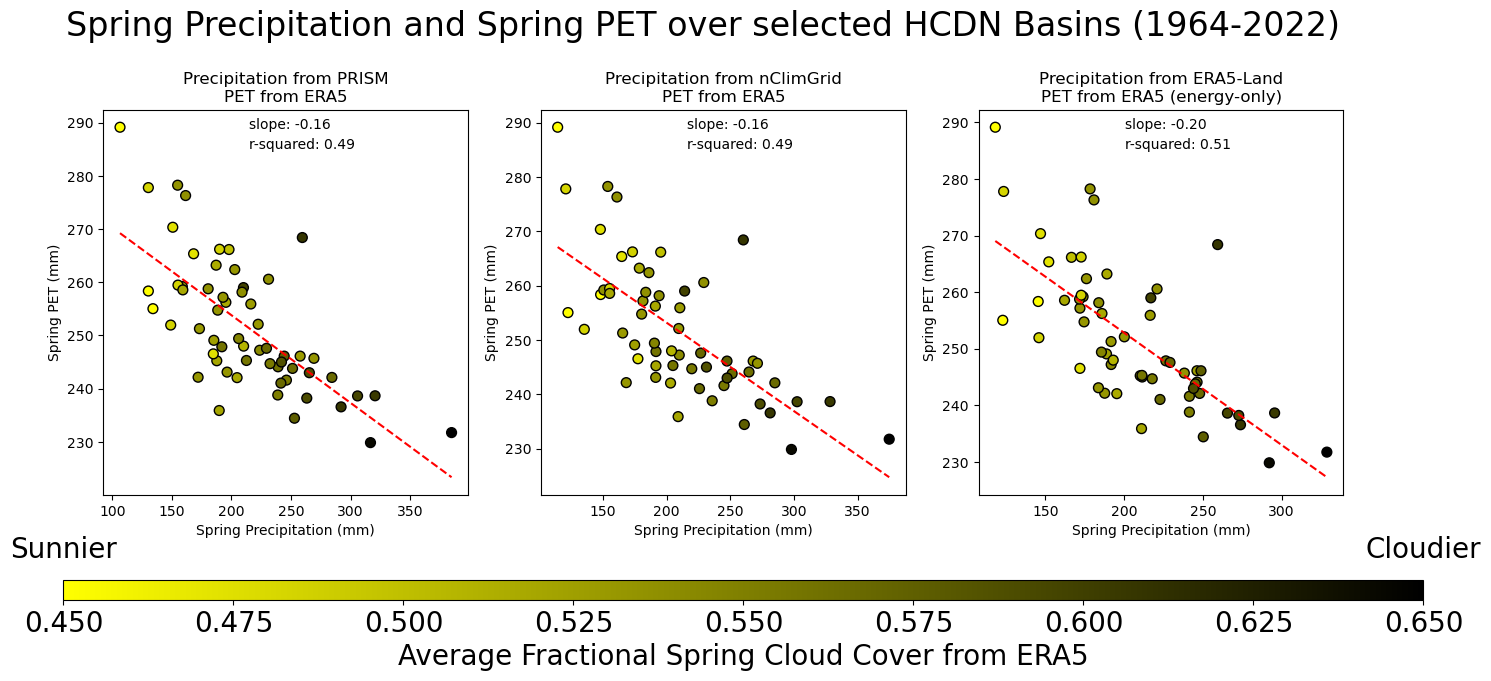

In [29]:
fig, axs = plt.subplots(ncols=3, figsize=(16,5))
ax = axs[0]
im=ax.scatter(hcdn_spring_ppt_prism_mean_2.values, 
           era5_pet_spring_mean.et_eo.values,
           c=total_cloud_cover.values,
           cmap=cmap,
           vmin=0.45,
           vmax=0.65,
           s=50,
           ec='k',)
# add a trend line from the ols model prism_results
ax.plot(np.sort(hcdn_spring_ppt_prism_mean_2.values), 
         prism_res.params[0]+prism_res.params[1]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  prism_res.conf_int()[0][0]+prism_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  prism_res.conf_int()[0][1]+prism_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and standard error (mm)
ax.text(0.4,0.95,f'slope: {prism_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {prism_res.rsquared:.2f}',transform=ax.transAxes)
# ax.text(0.4,0.85,f'standard error (mm): {prism_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest prism_residual
residuals = Y_prism - prism_res.params[0] - prism_res.params[1]*X_prism[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from PRISM\nPET from ERA5')

# add a second plot for nclimgrid
ax = axs[1]
ax.scatter(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values,
           Y_nclimgrid,
           c=total_cloud_cover,
           cmap=cmap,
           vmin=0.45,
           vmax=0.65,
           s=50,
           ec='k',)
# add a trend line from the ols model nclimgrid_results
ax.plot(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values), 
         nclimgrid_res.params[0]+nclimgrid_res.params[1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][0]+nclimgrid_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][1]+nclimgrid_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and p-value
ax.text(0.4,0.95,f'slope: {nclimgrid_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {nclimgrid_res.rsquared:.2f}',transform=ax.transAxes)
# ax.text(0.4,0.85,f'standard error (mm): {nclimgrid_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest nclimgrid_residual
residuals = Y_nclimgrid - nclimgrid_res.params[0] - nclimgrid_res.params[1]*X_nclimgrid[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from nClimGrid\nPET from ERA5')

# add a third plot for ERA5-Land
ax = axs[2]
ax.scatter(hcdn_era5_land_spring_mean['tp'].values, 
           Y_era5,
           c=total_cloud_cover,
           cmap=cmap,
           vmin=0.45,
           vmax=0.65,
           s=50,
           ec='k',)
# add a trend line from the ols model nclimgrid_results
ax.plot(np.sort(hcdn_era5_land_spring_mean['tp'].values), 
         era5_res.params[0]+era5_res.params[1]*np.sort(hcdn_era5_land_spring_mean.tp.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][0]+nclimgrid_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][1]+nclimgrid_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and p-value
ax.text(0.4,0.95,f'slope: {era5_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {era5_res.rsquared:.2f}',transform=ax.transAxes)
# ax.text(0.4,0.85,f'standard error (mm): {era5_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest nclimgrid_residual
residuals = Y_era5 - era5_res.params[0] - era5_res.params[1]*X_nclimgrid[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from ERA5-Land\nPET from ERA5 (energy-only)')
# add a colorbar for the entire figure
cbar_ax = fig.add_axes([0.1,-0.1, 0.85, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Average Fractional Spring Cloud Cover from ERA5', size=20)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=20)
# add annotations from sunnier on the right side of the colorbar to cloudier on the left side
fig.text(0.1, 0.0, 'Sunnier', size=20, ha='center', va='center')
fig.text(0.95, 0.0, 'Cloudier', size=20, ha='center', va='center')

fig.suptitle('Spring Precipitation and Spring PET over selected HCDN Basins (1964-2022)', size=24, y=1.08)

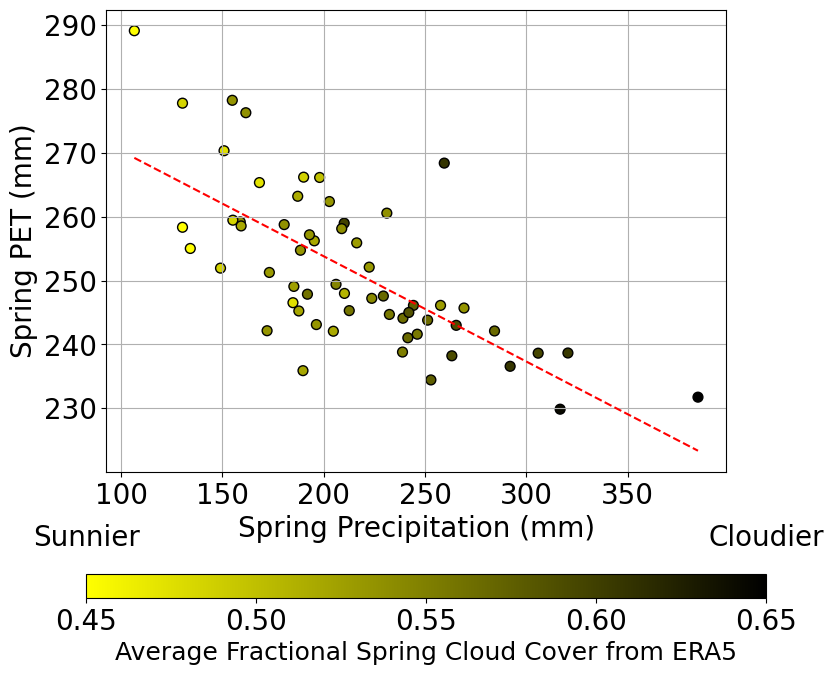

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
im=ax.scatter(hcdn_spring_ppt_prism_mean_2.values, 
           era5_pet_spring_mean.et_eo.values,
           c=total_cloud_cover.values,
           cmap=cmap,
           vmin=0.45,
           vmax=0.65,
           s=50,
           ec='k',)
# add a trend line from the ols model prism_results
ax.plot(np.sort(hcdn_spring_ppt_prism_mean_2.values), 
         prism_res.params[0]+prism_res.params[1]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  prism_res.conf_int()[0][0]+prism_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  prism_res.conf_int()[0][1]+prism_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and standard error (mm)
# ax.text(0.4,0.95,f'slope: {prism_res.params[1]:.2f}',transform=ax.transAxes)
# ax.text(0.4,0.90,f'r-squared: {prism_res.rsquared:.2f}',transform=ax.transAxes)
# increase the size of the x and y ticks
ax.tick_params(axis='both', which='major', labelsize=20)
# increase the size of the x and y labels
ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_ylabel(ax.get_ylabel(), fontsize=20)

# ax.text(0.4,0.85,f'standard error (mm): {prism_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest prism_residual
residuals = Y_prism - prism_res.params[0] - prism_res.params[1]*X_prism[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
# add a colorbar for the entire figure
cbar_ax = fig.add_axes([0.1,-0.1, 0.85, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# make the cbar ticks one decimal
cbar.set_ticks(np.arange(0.45,0.66,0.05))
cbar.set_label('Average Fractional Spring Cloud Cover from ERA5', size=18)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=20)
# add annotations from sunnier on the right side of the colorbar to cloudier on the left side
fig.text(0.1, 0.0, 'Sunnier', size=20, ha='center', va='center')
fig.text(0.95, 0.0, 'Cloudier', size=20, ha='center', va='center')

# ax.set_title('Spring Precipitation and Spring PET\nover selected HCDN Basins (1964-2022)', size=20,)
ax.grid()

### <a id='toc5_1_2_'></a>[CRU PET with CRU cloud cover and PPT](#toc0_)

In [31]:
# Calculate OLS regression
X_prism = hcdn_spring_ppt_prism_mean_2.values
X_prism = sm.add_constant(X_prism)
Y_prism = hcdn_spring_pet_cru_mean.values

prism_model = sm.OLS(Y_prism,X_prism)
prism_res = prism_model.fit()
prism_res.conf_int()


array([[ 3.13849952e+02,  3.42330914e+02],
       [-3.37341151e-01, -2.07391983e-01]])

In [32]:
# Calculate OLS regression
X_nclimgrid = hcdn_spring_ppt_nclimgrid_mean_2.prcp.values
X_nclimgrid = sm.add_constant(X_nclimgrid)
Y_nclimgrid = hcdn_spring_pet_cru_mean.values

nclimgrid_model = sm.OLS(Y_nclimgrid,X_nclimgrid)
nclimgrid_res = nclimgrid_model.fit()
nclimgrid_res.conf_int()

array([[ 3.11025603e+02,  3.39560607e+02],
       [-3.30000851e-01, -1.97689358e-01]])

In [33]:
# Calculate OLS regression
X_era5 = hcdn_era5_land_spring_mean['tp'].values
X_era5 = sm.add_constant(X_era5)
Y_era5 = hcdn_spring_pet_cru_mean.values

era5_model = sm.OLS(Y_era5,X_era5)
era5_res = era5_model.fit()
era5_res.conf_int()

array([[ 3.16837620e+02,  3.50640305e+02],
       [-3.89532496e-01, -2.28910851e-01]])

Text(0.5, 1.08, 'Spring Precipitation and Spring PET over selected HCDN Basins (1964-2022)')

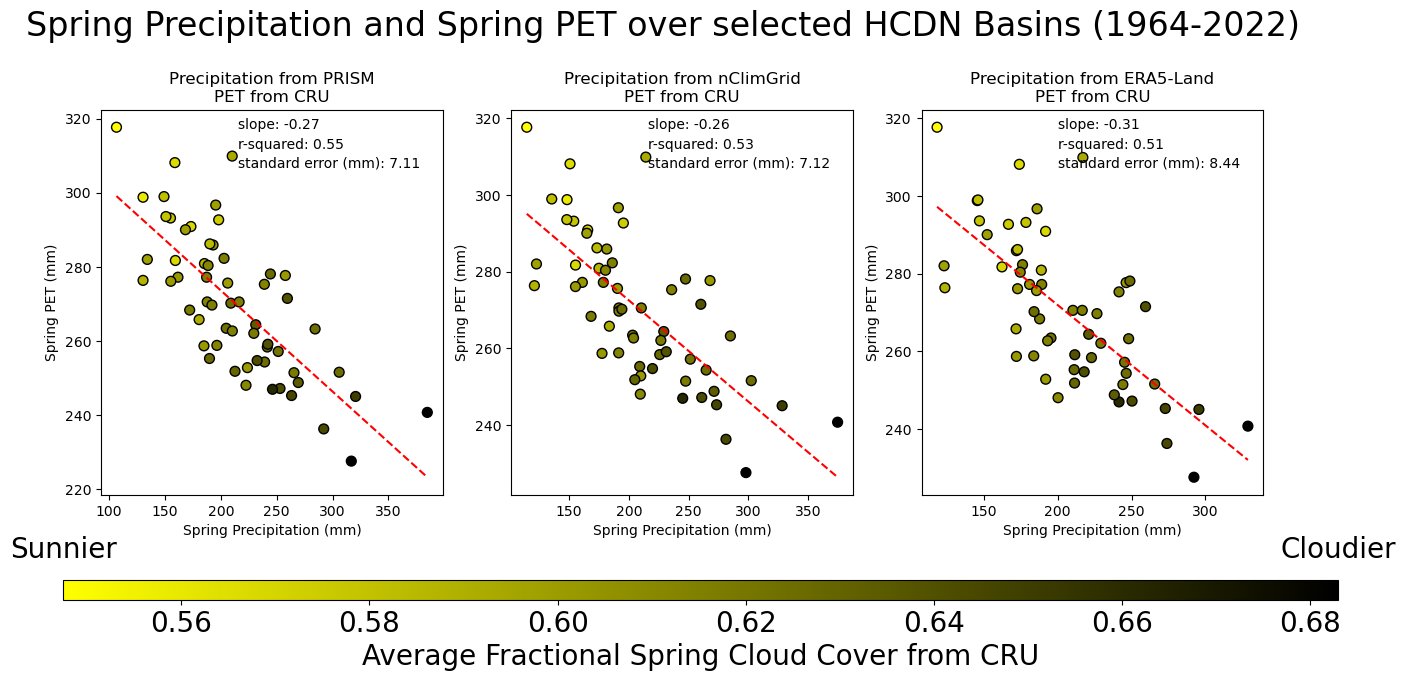

In [34]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
ax = axs[0]
im=ax.scatter(hcdn_spring_ppt_prism_mean_2.values, 
           hcdn_spring_pet_cru_mean.values,
           c=hcdn_spring_tcc_cru_mean,
           cmap=cmap,
        #    vmin=0.5,
        #    vmax=0.6,
           s=50,
           ec='k',)
# add a trend line from the ols model prism_results
ax.plot(np.sort(hcdn_spring_ppt_prism_mean_2.values), 
         prism_res.params[0]+prism_res.params[1]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  prism_res.conf_int()[0][0]+prism_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  prism_res.conf_int()[0][1]+prism_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and standard error (mm)
ax.text(0.4,0.95,f'slope: {prism_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {prism_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {prism_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest prism_residual
residuals = Y_prism - prism_res.params[0] - prism_res.params[1]*X_prism[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from PRISM\nPET from CRU')

# add a second plot for nclimgrid
ax = axs[1]
ax.scatter(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values,
           Y_nclimgrid,
           c=hcdn_spring_tcc_cru_mean,
           cmap=cmap,
        #    vmin=0.5,
        #    vmax=0.6,
           s=50,
           ec='k',)
# add a trend line from the ols model nclimgrid_results
ax.plot(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values), 
         nclimgrid_res.params[0]+nclimgrid_res.params[1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][0]+nclimgrid_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][1]+nclimgrid_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and p-value
ax.text(0.4,0.95,f'slope: {nclimgrid_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {nclimgrid_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {nclimgrid_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest nclimgrid_residual
residuals = Y_nclimgrid - nclimgrid_res.params[0] - nclimgrid_res.params[1]*X_nclimgrid[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from nClimGrid\nPET from CRU')

# add a third plot for ERA5-Land
ax = axs[2]
ax.scatter(hcdn_era5_land_spring_mean['tp'].values, 
           Y_era5,
           c=hcdn_spring_tcc_cru_mean,
           cmap=cmap,
        #    vmin=0.5,
        #    vmax=0.6,
           s=50,
           ec='k',)
# add a trend line from the ols model nclimgrid_results
ax.plot(np.sort(hcdn_era5_land_spring_mean['tp'].values), 
         era5_res.params[0]+era5_res.params[1]*np.sort(hcdn_era5_land_spring_mean.tp.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][0]+nclimgrid_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][1]+nclimgrid_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and p-value
ax.text(0.4,0.95,f'slope: {era5_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {era5_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {era5_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest nclimgrid_residual
residuals = Y_era5 - era5_res.params[0] - era5_res.params[1]*X_nclimgrid[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from ERA5-Land\nPET from CRU')
# add a colorbar for the entire figure
cbar_ax = fig.add_axes([0.1,-0.1, 0.85, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Average Fractional Spring Cloud Cover from CRU', size=20)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=20)
# add annotations from sunnier on the right side of the colorbar to cloudier on the left side
fig.text(0.1, 0.0, 'Sunnier', size=20, ha='center', va='center')
fig.text(0.95, 0.0, 'Cloudier', size=20, ha='center', va='center')

fig.suptitle('Spring Precipitation and Spring PET over selected HCDN Basins (1964-2022)', size=24, y=1.08)

### <a id='toc5_1_3_'></a>[GLEAM PET with cloud cover and PPT (1980-2022)](#toc0_)

In [35]:
# Calculate OLS regression
X_prism = hcdn_spring_ppt_prism_mean_2.sel(year=slice(1980,2022)).values
X_prism = sm.add_constant(X_prism)
Y_prism = hcdn_spring_pet_gleam.values

prism_model = sm.OLS(Y_prism,X_prism)
prism_res = prism_model.fit()
prism_res.conf_int()


array([[ 2.27176945e+02,  2.48080788e+02],
       [-2.02342382e-01, -1.08588457e-01]])

In [36]:
# Calculate OLS regression
X_nclimgrid = hcdn_spring_ppt_nclimgrid_mean_2.sel(year=slice(1980,2022)).prcp.values
X_nclimgrid = sm.add_constant(X_nclimgrid)
Y_nclimgrid = hcdn_spring_pet_gleam.values

nclimgrid_model = sm.OLS(Y_nclimgrid,X_nclimgrid)
nclimgrid_res = nclimgrid_model.fit()
nclimgrid_res.conf_int()

array([[ 2.23867169e+02,  2.45411550e+02],
       [-1.94634668e-01, -9.57727222e-02]])

In [37]:
# Calculate OLS regression
X_era5 = hcdn_era5_land_spring_mean.sel(year=slice(1980,2022))['tp'].values
X_era5 = sm.add_constant(X_era5)
Y_era5 = hcdn_spring_pet_gleam.values

era5_model = sm.OLS(Y_era5,X_era5)
era5_res = era5_model.fit()
era5_res.conf_int()

array([[ 2.24350061e+02,  2.50197997e+02],
       [-2.22296721e-01, -1.00115603e-01]])

Text(0.5, 1.08, 'Spring Precipitation and Spring PET over selected HCDN Basins (1964-2022)')

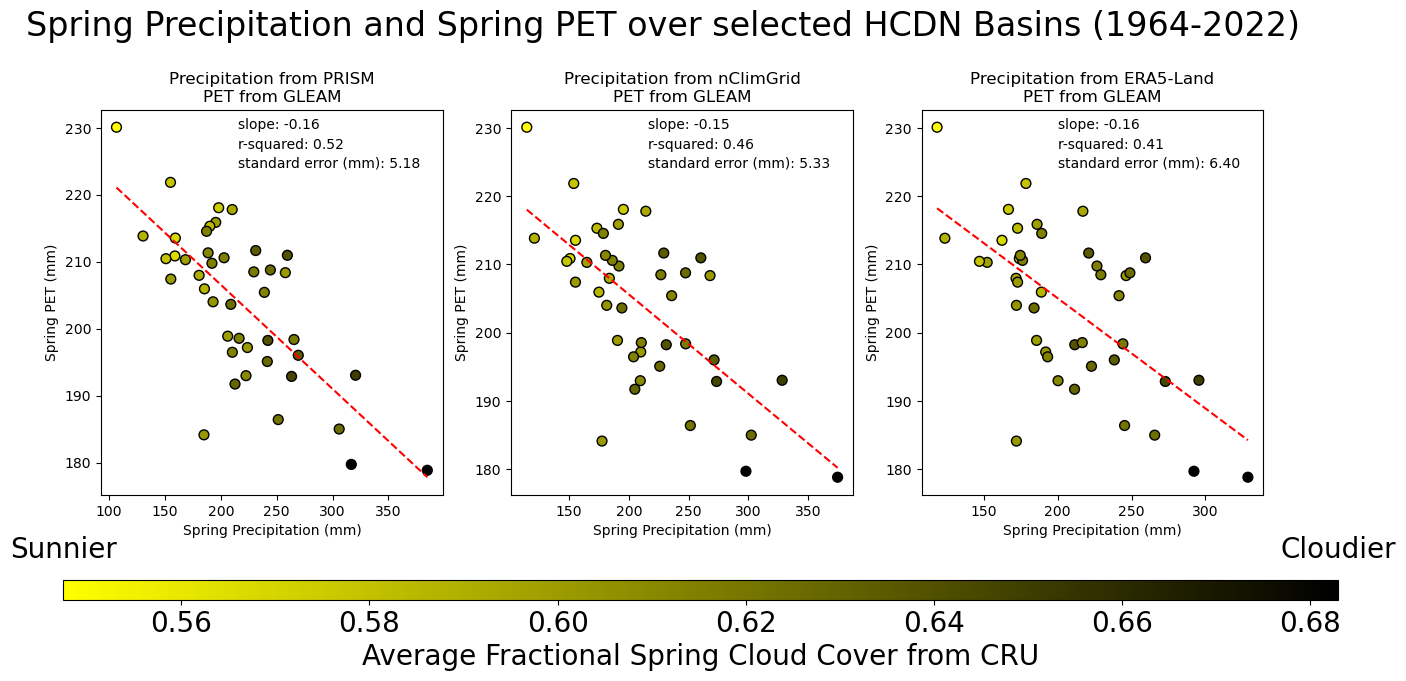

In [38]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
ax = axs[0]
im=ax.scatter(hcdn_spring_ppt_prism_mean_2.sel(year=slice(1980,2022)).values, 
           hcdn_spring_pet_gleam.values,
           c=hcdn_spring_tcc_cru_mean.sel(year=slice(1980,2022)),
           cmap=cmap,
        #    vmin=0.5,
        #    vmax=0.6,
           s=50,
           ec='k',)
# add a trend line from the ols model prism_results
ax.plot(np.sort(hcdn_spring_ppt_prism_mean_2.sel(year=slice(1980,2022)).values), 
         prism_res.params[0]+prism_res.params[1]*np.sort(hcdn_spring_ppt_prism_mean_2.sel(year=slice(1980,2022)).values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_prism_mean_2.sel(year=slice(1980,2022)).values),
#                  prism_res.conf_int()[0][0]+prism_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_prism_mean_2.sel(year=slice(1980,2022)).values),
#                  prism_res.conf_int()[0][1]+prism_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_prism_mean_2.sel(year=slice(1980,2022)).values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and standard error (mm)
ax.text(0.4,0.95,f'slope: {prism_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {prism_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {prism_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest prism_residual
residuals = Y_prism - prism_res.params[0] - prism_res.params[1]*X_prism[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.sel(year=slice(1980,2022)).year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from PRISM\nPET from GLEAM')

# add a second plot for nclimgrid
ax = axs[1]
ax.scatter(hcdn_spring_ppt_nclimgrid_mean_2.sel(year=slice(1980,2022)).prcp.values,
           Y_nclimgrid,
           c=hcdn_spring_tcc_cru_mean.sel(year=slice(1980,2022)),
           cmap=cmap,
        #    vmin=0.5,
        #    vmax=0.6,
           s=50,
           ec='k',)
# add a trend line from the ols model nclimgrid_results
ax.plot(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.sel(year=slice(1980,2022)).prcp.values), 
         nclimgrid_res.params[0]+nclimgrid_res.params[1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.sel(year=slice(1980,2022)).prcp.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.sel(year=slice(1980,2022)).prcp.values),
#                  nclimgrid_res.conf_int()[0][0]+nclimgrid_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.sel(year=slice(1980,2022)).prcp.values),
#                  nclimgrid_res.conf_int()[0][1]+nclimgrid_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.sel(year=slice(1980,2022)).prcp.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and p-value
ax.text(0.4,0.95,f'slope: {nclimgrid_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {nclimgrid_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {nclimgrid_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest nclimgrid_residual
residuals = Y_nclimgrid - nclimgrid_res.params[0] - nclimgrid_res.params[1]*X_nclimgrid[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.sel(year=slice(1980,2022)).year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from nClimGrid\nPET from GLEAM')

# add a third plot for ERA5-Land
ax = axs[2]
ax.scatter(hcdn_era5_land_spring_mean.sel(year=slice(1980,2022))['tp'].values, 
           Y_era5,
           c=hcdn_spring_tcc_cru_mean.sel(year=slice(1980,2022)),
           cmap=cmap,
        #    vmin=0.5,
        #    vmax=0.6,
           s=50,
           ec='k',)
# add a trend line from the ols model nclimgrid_results
ax.plot(np.sort(hcdn_era5_land_spring_mean.sel(year=slice(1980,2022))['tp'].values), 
         era5_res.params[0]+era5_res.params[1]*np.sort(hcdn_era5_land_spring_mean.sel(year=slice(1980,2022)).tp.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.sel(year=slice(1980,2022)).prcp.values),
#                  nclimgrid_res.conf_int()[0][0]+nclimgrid_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.sel(year=slice(1980,2022)).prcp.values),
#                  nclimgrid_res.conf_int()[0][1]+nclimgrid_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.sel(year=slice(1980,2022)).prcp.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and p-value
ax.text(0.4,0.95,f'slope: {era5_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {era5_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {era5_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest nclimgrid_residual
residuals = Y_era5 - era5_res.params[0] - era5_res.params[1]*X_nclimgrid[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.sel(year=slice(1980,2022)).year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from ERA5-Land\nPET from GLEAM')
# add a colorbar for the entire figure
cbar_ax = fig.add_axes([0.1,-0.1, 0.85, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Average Fractional Spring Cloud Cover from CRU', size=20)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=20)
# add annotations from sunnier on the right side of the colorbar to cloudier on the left side
fig.text(0.1, 0.0, 'Sunnier', size=20, ha='center', va='center')
fig.text(0.95, 0.0, 'Cloudier', size=20, ha='center', va='center')

fig.suptitle('Spring Precipitation and Spring PET over selected HCDN Basins (1964-2022)', size=24, y=1.08)

### <a id='toc5_1_4_'></a>[P-LSH ET with cloud cover and PPT](#toc0_)

In [39]:
# Calculate OLS regression
X_prism = hcdn_spring_ppt_prism_mean.values
X_prism = sm.add_constant(X_prism)
Y_prism = p_lsh_et_spring['monthly_ET'].mean(dim=['LAT','LON']).compute().values

prism_model = sm.OLS(Y_prism,X_prism)
prism_res = prism_model.fit()
prism_res.conf_int()


array([[ 1.48390452e+02,  1.73077051e+02],
       [-2.21404777e-01, -1.11621609e-01]])

In [40]:
# Calculate OLS regression
X_nclimgrid = hcdn_spring_ppt_nclimgrid_mean.prcp.values
X_nclimgrid = sm.add_constant(X_nclimgrid)
Y_nclimgrid = p_lsh_et_spring['monthly_ET'].mean(dim=['LAT','LON']).compute().values

nclimgrid_model = sm.OLS(Y_nclimgrid,X_nclimgrid)
nclimgrid_res = nclimgrid_model.fit()
nclimgrid_res.conf_int()

array([[ 1.46365589e+02,  1.71619019e+02],
       [-2.21280830e-01, -1.05613681e-01]])

In [41]:
total_cloud_cover_2 = total_cloud_cover.sel(year=slice(1982,2013))

Text(0.5, 1.08, 'Spring Precipitation and Spring PET over selected HCDN Basins (1982-2013)')

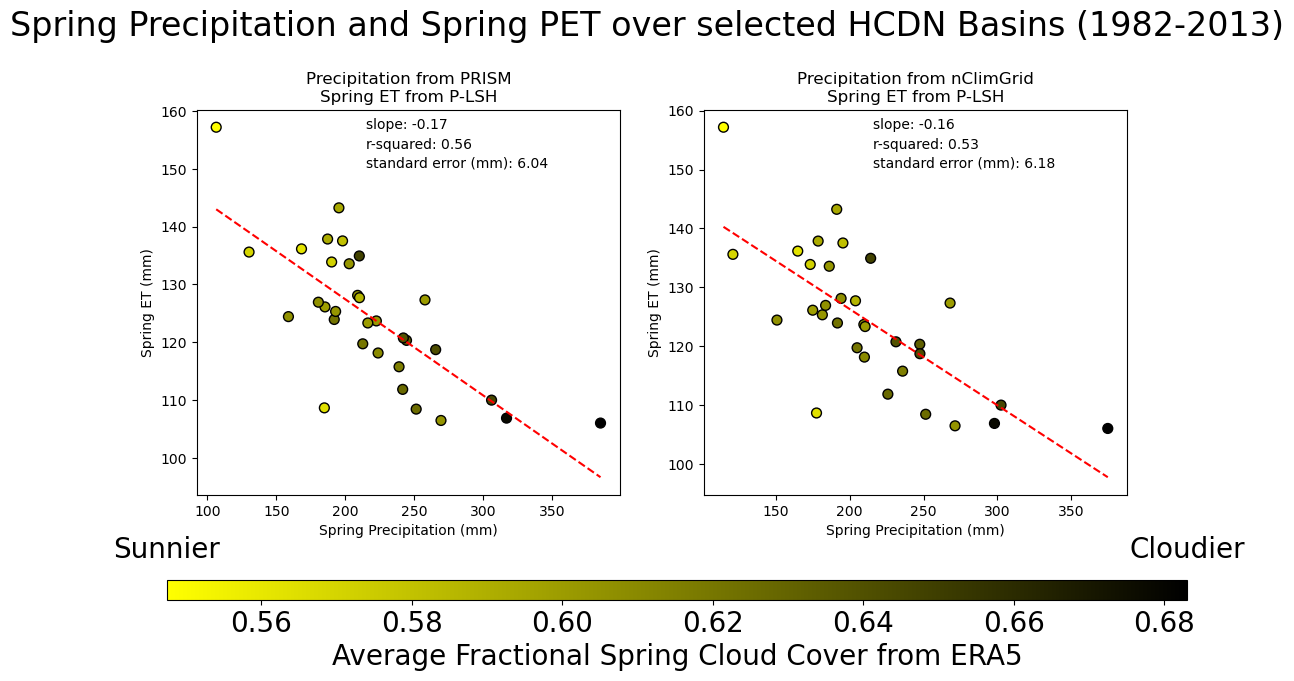

In [42]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
ax = axs[0]
ax.scatter(hcdn_spring_ppt_prism_mean.values, 
           p_lsh_et_spring['monthly_ET'].mean(dim=['LAT','LON']).compute().values,
           c=total_cloud_cover_2,
           cmap=cmap,
           vmin=0.45,
           vmax=0.65,
           s=50,
           ec='k',)
# add a trend line from the ols model prism_results
ax.plot(np.sort(hcdn_spring_ppt_prism_mean.values), 
         prism_res.params[0]+prism_res.params[1]*np.sort(hcdn_spring_ppt_prism_mean.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_prism_mean.values),
#                  prism_res.conf_int()[0][0]+prism_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_prism_mean.values),
#                  prism_res.conf_int()[0][1]+prism_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_prism_mean.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and standard error (mm)
ax.text(0.4,0.95,f'slope: {prism_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {prism_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {prism_res.bse[0]:.2f}',transform=ax.transAxes)

# find years with largest prism_residual
residuals = Y_prism - prism_res.params[0] - prism_res.params[1]*X_prism[:,1]
residuals = pd.Series(residuals,index=p_lsh_et_spring.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring ET (mm)')
ax.set_title('Precipitation from PRISM\nSpring ET from P-LSH')

# add a second plot for nclimgrid
ax = axs[1]
ax.scatter(hcdn_spring_ppt_nclimgrid_mean.prcp.values, 
           Y_nclimgrid,
           c=total_cloud_cover_2,
           cmap=cmap,
           vmin=0.45,
           vmax=0.65,
           s=50,
           ec='k',)
# add a trend line from the ols model nclimgrid_results
ax.plot(np.sort(hcdn_spring_ppt_nclimgrid_mean.prcp.values), 
         nclimgrid_res.params[0]+nclimgrid_res.params[1]*np.sort(hcdn_spring_ppt_nclimgrid_mean.prcp.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_nclimgrid_mean.prcp.values),
#                  nclimgrid_res.conf_int()[0][0]+nclimgrid_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_nclimgrid_mean.prcp.values),
#                  nclimgrid_res.conf_int()[0][1]+nclimgrid_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_nclimgrid_mean.prcp.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and p-value
ax.text(0.4,0.95,f'slope: {nclimgrid_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {nclimgrid_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {nclimgrid_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest nclimgrid_residual
residuals = Y_nclimgrid - nclimgrid_res.params[0] - nclimgrid_res.params[1]*X_nclimgrid[:,1]
residuals = pd.Series(residuals,index=p_lsh_et_spring.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring ET (mm)')
ax.set_title('Precipitation from nClimGrid\nSpring ET from P-LSH')
# add a colorbar for the entire figure
cbar_ax = fig.add_axes([0.1,-0.1, 0.85, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Average Fractional Spring Cloud Cover from ERA5', size=20)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=20)
# add annotations from sunnier on the right side of the colorbar to cloudier on the left side
fig.text(0.1, 0.0, 'Sunnier', size=20, ha='center', va='center')
fig.text(0.95, 0.0, 'Cloudier', size=20, ha='center', va='center')

fig.suptitle('Spring Precipitation and Spring PET over selected HCDN Basins (1982-2013)', size=24, y=1.08)

# <a id='toc6_'></a>[PET and Snow Cover with elevation](#toc0_)

#### <a id='toc6_1_1_1_'></a>[NLCD Land Cover](#toc0_)

In [43]:
# create an empty dataarray with the following dimension
ncols = 639
nrows = 894
xllcorner = -1072332.9030971
yllcorner = -721776.99064744
cellsize = 1000 
NODATA_value = -9999
values = pd.read_csv('../data/geodata/nlcd_landcover/nlcd_UCRB_daymet_resolution.txt', skiprows=6, header=None, delim_whitespace=True)
prj = "PROJCS['WGS_1984_Lambert_Conformal_Conic',GEOGCS['GCS_WGS_1984',DATUM['D_WGS_1984',SPHEROID['WGS_1984',6378137.0,298.257223563]],PRIMEM['Greenwich',0.0],UNIT['Degree',0.0174532925199433]],PROJECTION['Lambert_Conformal_Conic'],PARAMETER['False_Easting',0.0],PARAMETER['False_Northing',0.0],PARAMETER['Central_Meridian',-100.0],PARAMETER['Standard_Parallel_1',25.0],PARAMETER['Standard_Parallel_2',60.0],PARAMETER['Scale_Factor',1.0],PARAMETER['Latitude_Of_Origin',42.5],UNIT['m',1.0]]"
x = np.arange(xllcorner, xllcorner + ncols*cellsize, cellsize)
y = np.arange(yllcorner, yllcorner + nrows*cellsize, cellsize)[::-1]
x, y = np.meshgrid(x, y)
da = xr.DataArray(values.values, coords={'y': y[:, 0], 'x': x[0, :]}, dims=['y', 'x'])
# add the proj_string to the dataarray
da = da.rio.write_crs(prj)

In [44]:
da = rxr.open_rasterio('../data/geodata/nlcd_landcover/nlcd_UCRB_4326.tif').squeeze()
# replace values less than 0 with nan
da = da.where(da>=0, np.nan)

In [45]:

# create a dictionary for the NLCD landcover classes
nlcd_land_cover_types = {
    11: "Open Water",
    12: "Perennial Ice/Snow",
    21: "Developed, Open Space",
    22: "Developed, Low Intensity",
    23: "Developed, Medium Intensity",
    24: "Developed, High Intensity",
    31: "Barren Land (Rock/Sand/Clay)",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    51: "Dwarf Scrub",
    52: "Shrub/Scrub",
    71: "Grassland/Herbaceous",
    72: "Sedge/Herbaceous",
    73: "Lichens",
    74: "Moss",
    81: "Pasture/Hay",
    82: "Cultivated Crops",
    90: "Woody Wetlands",
    95: "Emergent Herbaceous Wetlands"
}
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define colors for each land cover type
colors = [
    '#aec7e8',  # Open Water
    '#1f78b4',  # Perennial Ice/Snow
    '#b2df8a',  # Developed, Open Space
    '#33a02c',  # Developed, Low Intensity
    '#fb9a99',  # Developed, Medium Intensity
    '#e31a1c',  # Developed, High Intensity
    '#fdbf6f',  # Barren Land (Rock/Sand/Clay)
    '#ff7f00',  # Deciduous Forest
    '#cab2d6',  # Evergreen Forest
    '#6a3d9a',  # Mixed Forest
    '#ffff99',  # Dwarf Scrub
    '#b15928',  # Shrub/Scrub
    '#b2df8a',  # Grassland/Herbaceous
    '#33a02c',  # Sedge/Herbaceous
    '#d9d9d9',  # Lichens
    '#8c510a',  # Moss
    '#bf812d',  # Pasture/Hay
    '#dfc27d',  # Cultivated Crops
    '#a6dba0',  # Woody Wetlands
    '#1b7837'   # Emergent Herbaceous Wetlands
]

# Create a colormap using ListedColormap
nlcd_colormap = ListedColormap(colors)

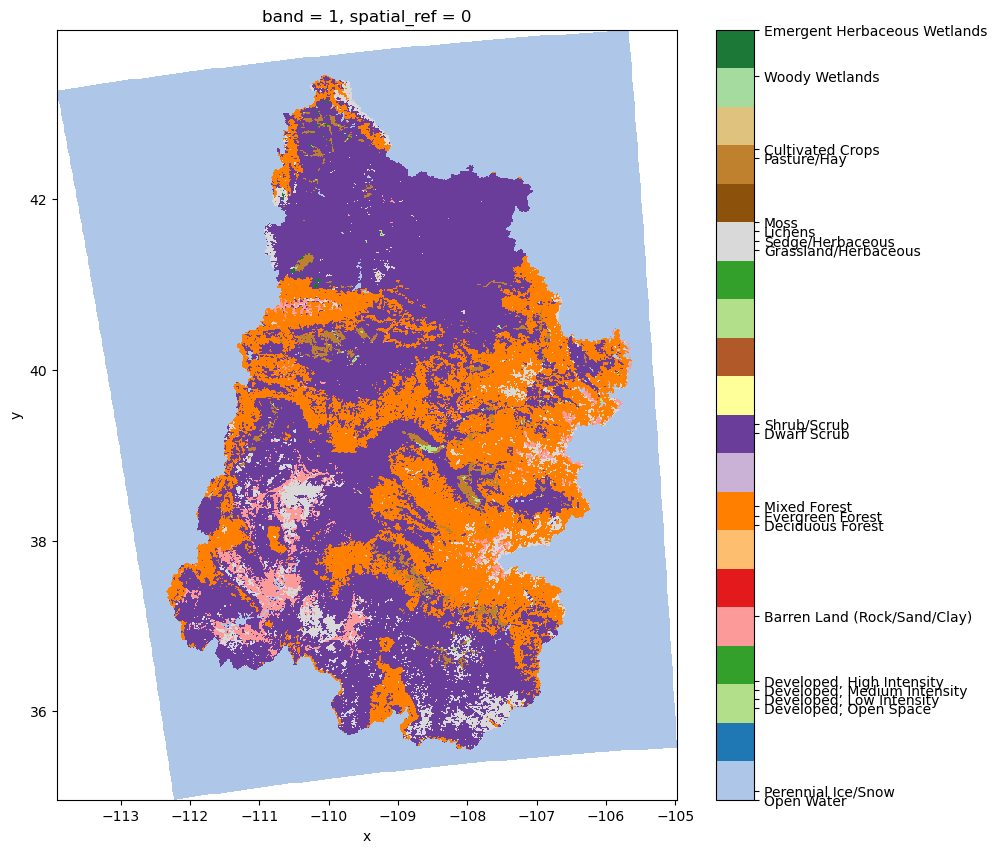

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
im = da.plot.imshow(ax=ax, cmap=nlcd_colormap, add_colorbar=False)
# for the colorbar, replace ticks with the land cover type
cbar = plt.colorbar(im, ticks=list(nlcd_land_cover_types.keys()))
cbar.ax.set_yticklabels([nlcd_land_cover_types[i] for i in nlcd_land_cover_types.keys()])
plt.show()

In [83]:
# filter to treed areas (41,42,43)
treed_areas = da.where(da.isin([41,42,43]),drop=True)
# untreed areas
untreed_areas = da.where(~da.isin([41,42,43]),drop=True)
# reproject tmean to match era5
treed_areas = treed_areas.rio.reproject_match(era5_land_ds_ucrb)
untreed_areas = untreed_areas.rio.reproject_match(era5_land_ds_ucrb)
# make values less than 0 nan
treed_areas = treed_areas.where(treed_areas>=0,np.nan)
untreed_areas = untreed_areas.where(untreed_areas>=0,np.nan)

tmean = prism_tmean.rio.reproject_match(era5_land_ds_ucrb)
# values less than 0 are nan
tmean = tmean.where(tmean>-1,np.nan)
# clip tmean by treed areas
tmean_treed = tmean.where(treed_areas.notnull(), np.nan)
# rename month to time
tmean_treed = tmean_treed.rename({'month':'time'})
# convert time to datetime64
tmean_treed['time'] = pd.to_datetime(tmean_treed['time'].values.astype('str'))

In [84]:
# pull in ucrb modis sca
ucrb_modis_sca_fine = xr.open_dataset('../data/snowdata/modis_sca/processed/ucrb_modis_sca.nc')
# add crs as 4326
ucrb_modis_sca = ucrb_modis_sca_fine.rio.write_crs(4326)
# resample to era5_land_ds grid
ucrb_modis_sca = ucrb_modis_sca.rio.reproject_match(era5_land_ds_ucrb)

In [85]:
# resample to monthly mean
monthly_ucrb_modis_sca = ucrb_modis_sca.resample(time='1MS').mean()
# add crs
monthly_ucrb_modis_sca = monthly_ucrb_modis_sca.rio.write_crs(4326)
# reproject to match era5_land_ds_ucrb
monthly_ucrb_modis_sca = monthly_ucrb_modis_sca.rio.reproject_match(era5_land_ds_ucrb)

# era5 subset
era5_subset = era5_land_ds_ucrb.sel(time=slice('2000-03-01','2017-02-01'))
# rename latitude, longitude to x, y
era5_subset = era5_subset.rename({'latitude':'y','longitude':'x'})
# where tmean treed is nan, set to 0
era5_subset_tree_masked_1 = era5_subset.where(tmean_treed.sel(time=slice('2000-03-01','2017-02-01')).notnull(),np.nan)
# add back in vlues not in the treed areas
era5_subset_tree_masked_2 = era5_subset.where(untreed_areas.notnull(),np.nan)

era5_subset_tree_masked = era5_subset_tree_masked_2.where(era5_subset_tree_masked_2.notnull(), era5_subset_tree_masked_1)
# select all cells where the sca is greater than 0.1
era5_subset_sca_masked = era5_subset_tree_masked.where(monthly_ucrb_modis_sca.Snow_Cover_Extent==0,np.nan)


# replace values less than 0 with nan
era5_subset_masked = era5_subset_sca_masked.where(era5_subset_sca_masked>=0, np.nan)
# make all values outside the ucrb boundary np.nan
era5_subset_masked = era5_subset_masked.rio.clip(ucrb_boundary_4326.geometry, all_touched=True)



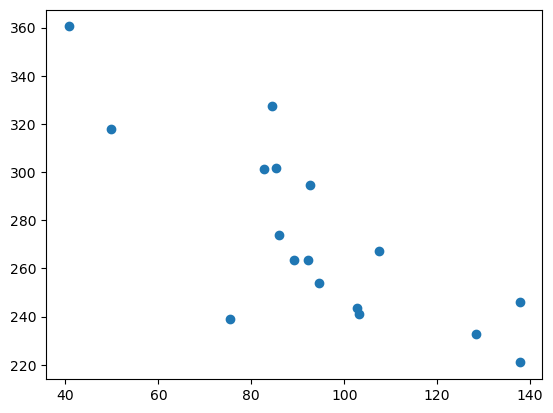

In [86]:
# get the springtime totals for each year
era5_land_spring_subset = era5_subset_masked.where(era5_subset_masked.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').mean('time').mean(dim=['x','y'])
# plot against the springtime precipitation from prism
fig, ax = plt.subplots()
ax.scatter(ucrb_spring_ppt.mean(dim=['x','y']).sel(year=slice(2000,2016)), era5_land_spring_subset.pev, label='ERA5-Land')

In [87]:
# make a hypsometric plot of PET with elevation
era5_data = era5_subset_masked.where(era5_subset_masked.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')

# replace 0 with nan
era5_data = era5_data.where(era5_data>=0,np.nan)
# replace unrealistic values > 1000 with nan
era5_data = era5_data.where((era5_data<900) | (~era5_data.notnull()),800)
# add the elevation data
d = rxr.open_rasterio('../data/geodata/ucrb_dem_32613_150m.tif').squeeze()
# calculate the area of 100 m elevation bins
dem_area = d.copy()
dem_area.name='elevation'
# convert to dataset
dem_area = dem_area.to_dataset()
dem_area = dem_area.rio.reproject_match(era5_land_ds_ucrb)
dem_area = dem_area.where(dem_area>0,np.nan)
# convert dem resolution to meters
area = np.full_like(dem_area.squeeze().to_array()[0], 10130.37725989001 * 10130.37725989001)
# add the area of each grid cell to the dataset
dem_area['area'] = xr.DataArray(area, coords=dem_area.coords)


# reproject to match era5
dem = d.rio.reproject_match(era5_land_ds_ucrb)
# make values less than 0 nan
dem = dem.where(dem>0,np.nan)
# add the elevation data to the era5 data
era5_data['elevation'] = dem
# add elevation to treed areas
treed_areas.name = 'tree_cover'
treed_areas = treed_areas.to_dataset()
treed_areas['elevation'] = dem
treed_areas['tree_cover'] = treed_areas['tree_cover'].where(treed_areas['tree_cover'].notnull(),0)
treed_areas['tree_cover'] = treed_areas['tree_cover'].where(treed_areas['tree_cover']==0,1)

In [101]:
treed_areas.where(treed_areas['elevation']>2278,drop=True).elevation.max()

<xarray.DataArray 'elevation' ()>
array(4148.2114, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [100]:
a = treed_areas.where(treed_areas['elevation']>2278,drop=True).rio.clip(hcdn_boundaries_4326.geometry)
a.where(a>=0).elevation.min()

<xarray.DataArray 'elevation' ()>
array(2291.6458, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [89]:
tree_covered_area = rxr.open_rasterio('../data/geodata/nlcd_landcover/ucrb_tree_cover_fraction_cleaned.tif').squeeze()

In [90]:
# resample to 150 m resolution
tree_covered_area = tree_covered_area.rio.reproject_match(d)

In [102]:

# crop to ucrb
tree_covered_area = tree_covered_area.rio.clip(ucrb_boundary_4326.to_crs(32613).geometry, all_touched=True)
# replace values above 100 with nan
tree_covered_area = tree_covered_area.where(tree_covered_area<=100,np.nan)
# convert to dataset and name 
tree_covered_area.name = 'tree_cover'
tree_covered_area = tree_covered_area.to_dataset()
# add the dem
tree_covered_area['elevation'] = d

In [113]:
a = tree_covered_area
a.where(a>100).elevation.max()

<xarray.DataArray 'elevation' ()>
array(4313.8003, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [55]:
tree_covered_area_bins = (tree_covered_area.groupby_bins('elevation', np.arange(tree_covered_area.elevation.min(),
                                  tree_covered_area.elevation.max(),
                                  100)).mean().tree_cover/100)

### <a id='toc6_1_2_'></a>[Get MODIS SCA](#toc0_)

In [56]:
# resample to monthly mean
monthly_ucrb_modis_sca_fine = ucrb_modis_sca_fine.resample(time='1MS').mean()

In [57]:
# get ready to plot modis SCA
spring_modis_sca = monthly_ucrb_modis_sca_fine.where(monthly_ucrb_modis_sca_fine.time.dt.month.isin([3,4,6]), drop=True).groupby('time.year').mean()
spring_modis_sca = spring_modis_sca.where(spring_modis_sca>=0, np.nan)
# add dem to modis sca
dem_sca = d.rio.reproject_match(spring_modis_sca)
# replace values less than 0 with nan
dem_sca = dem_sca.where(dem_sca>0, np.nan)
spring_modis_sca['elevation'] = dem_sca

### <a id='toc6_1_3_'></a>[Get more accurate tree covered area](#toc0_)

### <a id='toc6_1_4_'></a>[Hypsometric Figures](#toc0_)

Text(0.5, 1.05, 'Hypsometric Plot of Spring PET (ERA5) and Elevation')

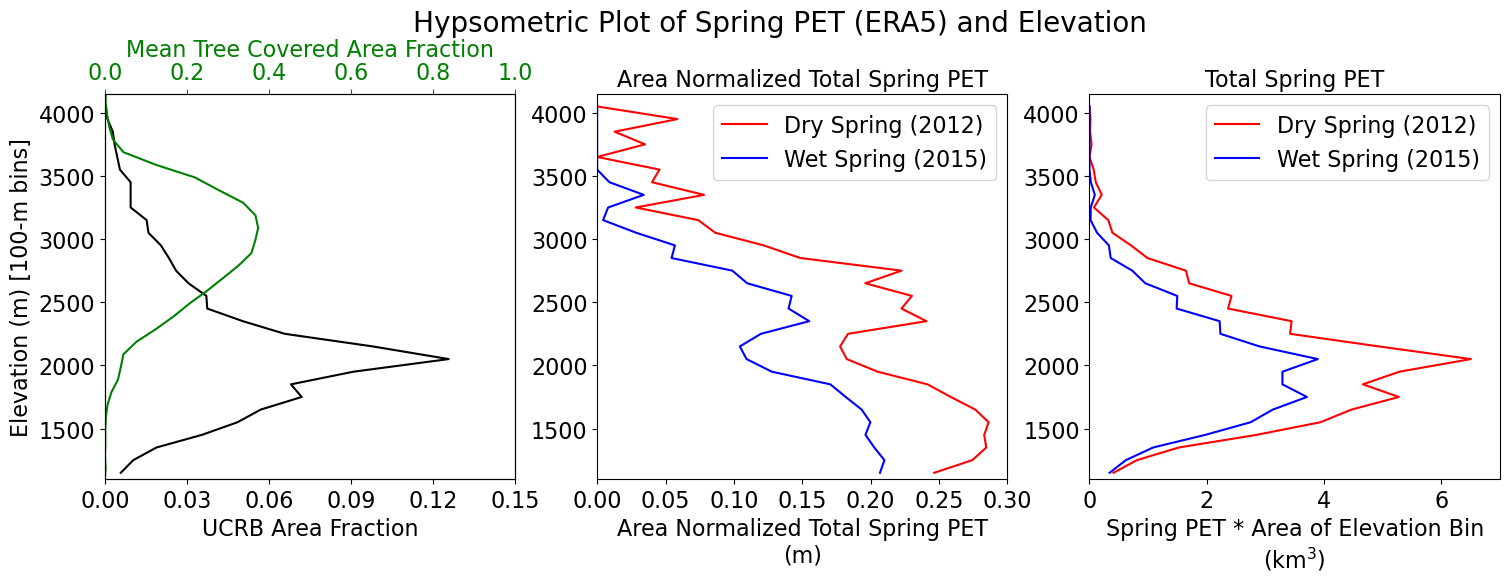

In [58]:
fig, axs = plt.subplots(ncols=3, figsize=(18,5))
ax = axs[0]
((dem_area.groupby_bins('elevation',
                        np.arange(era5_data.elevation.min(),
                                  era5_data.elevation.max(),
                                  100)).sum()).area/(dem_area.groupby_bins('elevation',
                                                                           np.arange(era5_data.elevation.min(),
                                                                                     era5_data.elevation.max(),
                                                                                     100)).sum()).area.sum()).plot(y='elevation_bins', 
                                                                                                                   ax=ax,
                                                                                                                   color='k')
ax.set_xlabel('UCRB Area Fraction')
ax2 = ax.twiny()
tree_covered_area_bins.plot(y='elevation_bins',ax=ax2, color='g')
ax2.set_xlabel('Mean Tree Covered Area Fraction', color='g', fontsize=16)
# make the ticks green
for tl in ax2.get_xticklabels():
    tl.set_color('g')
    tl.set_fontsize(16)
ax2.tick_params(axis='x', colors='g')
ax2.set_xlim(0,1)
ax2.set_title('')
ax.set_ylabel('Elevation (m) [100-m bins]')
ax.set_title('')
ax.set_xlim(0,0.15)
ax.set_xticks(np.arange(0,0.16,0.03))


ax = axs[1]
binned_pev = 0.5 * era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().pev / 1000
# binned_pev = binned_pev * 10130.37725989001 * 10130.37725989001 / 1e9
binned_pev.sel(year=2012).plot(y='elevation_bins',
ax=ax, 
color='r', 
label = 'Dry Spring (2012)')
binned_pev.sel(year=2015).plot(y='elevation_bins',
ax=ax, 
color='b',
label = 'Wet Spring (2015)')
ax.legend(fontsize=16)
ax.set_xlabel('Area Normalized Total Spring PET\n(m)')
ax.set_ylabel('')
ax.set_title('Area Normalized Total Spring PET')
ax.set_xlim(0,0.3)

ax = axs[2]
binned_pev = 0.45 * era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).sum().pev / 1000
binned_pev = binned_pev * 10130.37725989001 * 10130.37725989001 / 1e9

binned_pev.sel(year=2012).plot(y='elevation_bins',
ax=ax, 
color='r', 
label = 'Dry Spring (2012)')
binned_pev.sel(year=2015).plot(y='elevation_bins',
ax=ax, 
color='b',
label = 'Wet Spring (2015)')
ax.legend(fontsize=16)
ax.set_xlabel('Spring PET * Area of Elevation Bin\n(km$^3$)')
ax.set_ylabel('')
ax.set_title('Total Spring PET')
ax.set_xlim(0,7)

for ax in axs:
    ax.set_ylim(era5_data.elevation.min(),era5_data.elevation.max())
    # increase the font size for all x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=16)
    # increase the font size for x and y labels
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=16)
fig.suptitle('Hypsometric Plot of Spring PET (ERA5) and Elevation', fontsize=20, y=1.05)

Text(0.5, 1.2, 'Hypsometric Plot of Spring PET (ERA5) and Elevation')

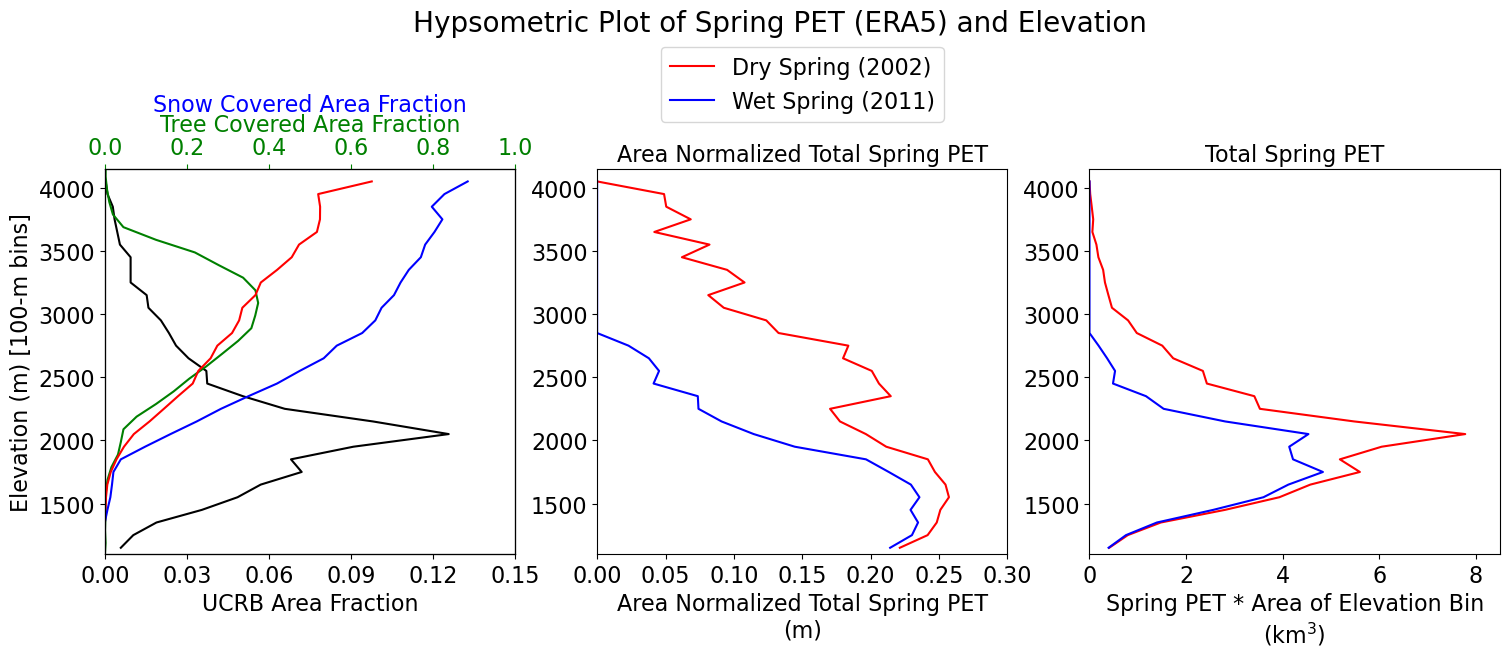

In [59]:
fig, axs = plt.subplots(ncols=3, figsize=(18,5))
ax = axs[0]
((dem_area.groupby_bins('elevation',
                        np.arange(era5_data.elevation.min(),
                                  era5_data.elevation.max(),
                                  100)).sum()).area/(dem_area.groupby_bins('elevation',
                                                                           np.arange(era5_data.elevation.min(),
                                                                                     era5_data.elevation.max(),
                                                                                     100)).sum()).area.sum()).plot(y='elevation_bins', 
                                                                                                                   ax=ax,
                                                                                                                   color='k')
ax.set_xlabel('UCRB Area Fraction')
ax2 = ax.twiny()
tree_covered_area_bins.plot(y='elevation_bins',ax=ax2, color='g')
spring_modis_sca.groupby_bins('elevation', np.arange(era5_data.elevation.min(),
                                                    era5_data.elevation.max(),
                                                    100)).mean().Snow_Cover_Extent.sel(year=2002).plot(y='elevation_bins',ax=ax2, color='r', label='Dry Spring (2002)')
spring_modis_sca.groupby_bins('elevation', np.arange(era5_data.elevation.min(),
                                                    era5_data.elevation.max(),
                                                    100)).mean().Snow_Cover_Extent.sel(year=2011).plot(y='elevation_bins',ax=ax2, color='b', label='Wet Spring (2011)')
ax2.set_xlabel('Tree Covered Area Fraction', color='g', fontsize=16)
# make the ticks green
for tl in ax2.get_xticklabels():
    tl.set_color('g')
    tl.set_fontsize(16)
ax2.tick_params(axis='x', colors='g')
ax2.set_xlim(0,1)
ax2.set_title('')
# add another axis on top of ax2
ax3 = ax.twiny()
ax3.set_xlim(0,1)
ax3.set_xlabel('Snow Covered Area Fraction', color='b', fontsize=16)
# move the xlable up a bit
ax3.xaxis.set_label_coords(0.5, 1.15)
# turn off the ticks and tick labels

ax3.set_xticks([])
ax3.set_xticklabels([])


ax.set_ylabel('Elevation (m) [100-m bins]')
ax.set_title('')
ax.set_xlim(0,0.15)
ax.set_xticks(np.arange(0,0.16,0.03))

ax = axs[1]
binned_pev = 0.45*era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().pev / 1000
# binned_pev = binned_pev * 10130.37725989001 * 10130.37725989001 / 1e9
binned_pev.sel(year=2002).plot(y='elevation_bins',
ax=ax, 
color='r', 
label = 'Dry Spring (2002)')
binned_pev.sel(year=2011).plot(y='elevation_bins',
ax=ax, 
color='b',
label = 'Wet Spring (2011)')
ax.legend(fontsize=16, bbox_to_anchor=(0.5, 1.22), loc='center')
ax.set_xlabel('Area Normalized Total Spring PET\n(m)')
ax.set_ylabel('')
ax.set_title('Area Normalized Total Spring PET')
ax.set_xlim(0,0.3)


ax = axs[2]
binned_pev = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).sum().pev / 1000
binned_pev = 0.45*binned_pev * 10130.37725989001 * 10130.37725989001 / 1e9

binned_pev.sel(year=2002).plot(y='elevation_bins',
ax=ax, 
color='r', 
label = 'Dry Spring (2002)')
binned_pev.sel(year=2011).plot(y='elevation_bins',
ax=ax, 
color='b',
label = 'Wet Spring (2011)')
ax.set_xlabel('Spring PET * Area of Elevation Bin\n(km$^3$)')
ax.set_ylabel('')
ax.set_title('Total Spring PET')
ax.set_xlim(0,8.5)

for ax in axs:
    ax.set_ylim(era5_data.elevation.min(),era5_data.elevation.max())
    # increase the font size for all x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=16)
    # increase the font size for x and y labels
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=16)
fig.suptitle('Hypsometric Plot of Spring PET (ERA5) and Elevation', fontsize=20, y=1.2)

Text(0.5, 1.0, 'ERA5 Precipitation Totals by 100-meter Elevation Bands')

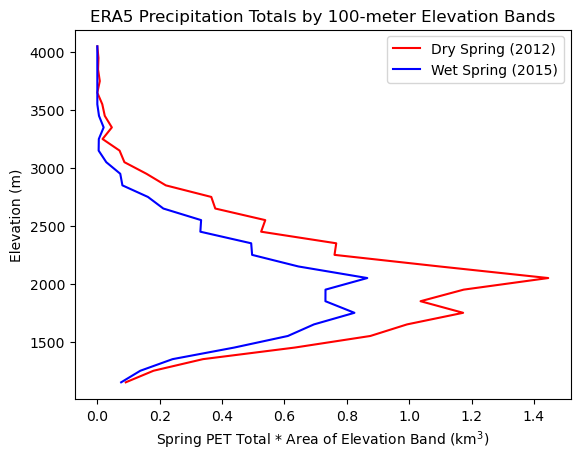

In [60]:
# bin the elevation data into 100m bins
fig, ax = plt.subplots()

binned_pev = 0.1 * era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).sum().pev / 1000
binned_pev = binned_pev * 10130.37725989001 * 10130.37725989001 / 1e9


binned_pev.sel(year=2012).plot(y='elevation_bins',
ax=ax, 
color='r', 
label = 'Dry Spring (2012)')
binned_pev.sel(year=2015).plot(y='elevation_bins',
ax=ax, 
color='b',
label = 'Wet Spring (2015)')
ax.legend()
ax.set_xlabel('Spring PET Total * Area of Elevation Band (km$^3$)')
ax.set_ylabel('Elevation (m)')
ax.set_title('ERA5 Precipitation Totals by 100-meter Elevation Bands')

# <a id='toc7_'></a>[Plot PET against Spring P colored by Tmean](#toc0_)

### <a id='toc7_1_1_'></a>[Assessing temporal trend in temperature vs. spring preciptiation relationship](#toc0_)

In [67]:
spring_mean_ucrb_temp_anomaly

<xarray.DataArray '__xarray_dataarray_variable__' (year: 93, y: 200, x: 169)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -112.3 -112.2 -112.2 ... -105.7 -105.7 -105.6
  * y            (y) float64 43.44 43.4 43.36 43.32 ... 35.7 35.66 35.62 35.58
    spatial_ref  int64 0
  * year         (year) int64 1930 1931 1932 1933 1934 ... 2019 2020 2021 2022

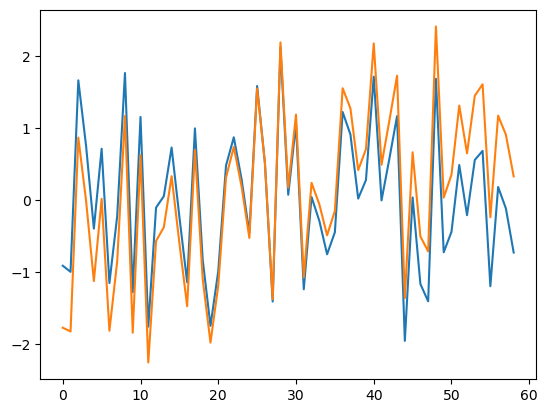

In [68]:
from scipy.signal import detrend
# clip to hcdn boundary
prism_spring_temp_anomaly = spring_mean_ucrb_temp_anomaly.sel(year=slice(1964,2022)).rio.clip(hcdn_boundaries_4326.geometry, all_touched=True).mean(dim=['x','y'])
# remove the trend in the temperature anomaly
prism_spring_temp_anomaly_detrended = detrend(prism_spring_temp_anomaly, type='linear')
plt.plot(prism_spring_temp_anomaly_detrended)
plt.plot(prism_spring_temp_anomaly)

In [70]:

prism_spring_ppt = hcdn_spring_ppt_prism.where(hcdn_spring_ppt_prism>0,np.nan).mean(dim=['x','y'])


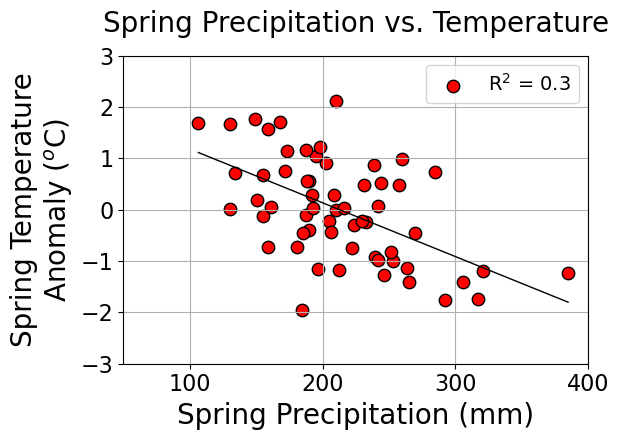

In [83]:
fig, ax = plt.subplots(figsize=(6,4))
years_of_interest=slice(1964,2022)
# add an r2 value
slope, intercept, r_value, p_value, std_err = stats.linregress(prism_spring_ppt.sel(year=years_of_interest),prism_spring_temp_anomaly_detrended)
ax.scatter(prism_spring_ppt.sel(year=years_of_interest),prism_spring_temp_anomaly_detrended,
           color='r',
           ec='k',
           s=80,
           label='R$^2$ = '+str(round(r_value**2,2)))
# add best fit line
x = prism_spring_ppt.sel(year=years_of_interest).sortby(prism_spring_ppt.sel(year=years_of_interest))
y_predicted = slope*x + intercept
ax.plot(x, y_predicted, '-', color='k', linewidth=1)
ax.legend(fontsize=14)
ax.set_ylabel('Spring Temperature\nAnomaly ($^o$C)',size=20)
ax.set_xlabel('Spring Precipitation (mm)',size=20)
ax.set_title('Spring Precipitation vs. Temperature',size=20, y=1.05)
ax.set_xlim(50,400)
ax.set_ylim(-3,3)
ax.grid()
# increase the ticklabel size for x and y axes
ax.tick_params(axis='both', which='major', labelsize=16)

## <a id='toc7_2_'></a>[PRISM UCRB Thornthwaite Estimate](#toc0_)

In [81]:
def vectorize_thornthwaite_pet(tmean, N, _MONTHDAYS):
    """
    Vectorized version of the Thornthwaite PET equation. Input arrays must have the same dimensions. 
    Can be used to estimate PET from monthly mean temperature from PRISM and monthly mean daylight hours from latitude.
    Time index must be in years (e.g. 1987, 1988, 1989, etc.) repeated over for the number of each year's months (e.g. 1987, 1987, 1987, etc.)
    Inputs:
        tmean: mean monthly temperature (deg C), dimensions (time, lat, lon)
        N: mean monthly daylight hours (hours), dimensions (time, lat)  
        _MONTHDAYS: number of days in each month (days), dimensions (time)
    Returns:
        pet: monthly PET (mm/month)

    """
    # Negative temperatures should be set to zero
    adj_monthly_t = tmean * (tmean >= 0)
    # create empty arrays to be filled
    I = xr.zeros_like(adj_monthly_t)
    alpha = xr.zeros_like(adj_monthly_t)
    pet = xr.zeros_like(adj_monthly_t)
    # Iterate through each year
    for year in tmean.month.to_series().unique():
        # calculate the heat index for each year 
        I.loc[year] += (adj_monthly_t.where(adj_monthly_t>0).sel(month=year) / 5.0) ** 1.514
        # calculate the alpha multiplier for each year
        alpha.loc[year] = (6.75e-07 * I.loc[year].sum() ** 3) - (7.71e-05 * I.loc[year].sum() ** 2) + (1.792e-02 * I.loc[year].sum() + 0.49239)
        # estimate PET using the Thornthwaite equation for each year
        pet.loc[year] = 16*(N.sel(month=year).transpose()/12)*(_MONTHDAYS.sel(month=year)/30)*(10*adj_monthly_t.sel(month=year)/I.loc[year].sum())**alpha.loc[year]
    return pet

In [ ]:
def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    """
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = np.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = np.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return np.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)

In [ ]:
def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    """
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = np.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = np.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return np.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)